In [619]:
import pandas as pd 
import numpy as np
import csv
import matplotlib.pyplot as plt


In [620]:
#Lee bases de datos
Color_pd = pd.read_csv("D:\home\[00]_Projects\[01]_School\MachineLearning\Bases_datos\Color.csv")
Forma_pd = pd.read_csv("D:\home\[00]_Projects\[01]_School\MachineLearning\Bases_datos\Forma.csv")
Iluminancia_pd = pd.read_csv("D:\home\[00]_Projects\[01]_School\MachineLearning\Bases_datos\Iluminancia.csv")
Output_pd = pd.read_csv("D:\home\[00]_Projects\[01]_School\MachineLearning\Bases_datos\outputActualizado.csv")

Limpiamos la base de datos outpu

In [621]:
Output_pd = Output_pd.dropna()

In [622]:
Output_pd.head()

,Unnamed: 0,ParticipantNumber,RoomID,MemoryTest1,MemoryTest2,MemoryTest3,MemoryAverage,AttentionTest
3,4,1,111,5.0,9.0,7.0,7.000000,698.86
4,5,1,25,9.0,9.0,8.0,8.666667,675.79
5,6,1,86,5.0,8.0,10.0,7.666667,440.42
6,7,1,118,7.0,6.0,8.0,7.000000,471.30
7,8,1,46,6.0,9.0,8.0,7.666667,442.17


In [623]:
check_no_alpha = Output_pd['RoomID'].str.isnumeric()
Output_pd = Output_pd[check_no_alpha]

#Cambiamos el nombre de la columna de Room Id del output y le cambiamos el tipo
Output_pd['RoomID'] = Output_pd['RoomID'].astype('int64')

In [624]:
significant = ['RoomID', 'MemoryAverage']

In [625]:
Output_pd = Output_pd[significant]

In [626]:
Output_pd.head()

,RoomID,MemoryAverage
3,111,7.000000
4,25,8.666667
5,86,7.666667
6,118,7.000000
7,46,7.666667


In [632]:

# Definir los límites de cuantiles para la estratificación
cuantiles = [0, 0.24, 0.5, 0.75, 1]

# Aplicar la estratificación basada en cuantiles
Output_pd['Grupo'] = pd.qcut(Output_pd['MemoryAverage'], cuantiles, labels=['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4'])

# Imprimir la distribución de grupos
print(Output_pd['Grupo'].value_counts())

Grupo
Grupo_2    335
Grupo_3    330
Grupo_1    311
Grupo_4    300
Name: count, dtype: int64


In [633]:
# Convertir la columna de grupos a valores numéricos
Output_pd['Grupo'] = Output_pd['Grupo'].astype('category').cat.codes

# Imprimir la distribución de grupos
print(Output_pd['Grupo'].value_counts())
Output_pd['Grupo'] = Output_pd['Grupo'] + 1

Grupo
1    335
2    330
0    311
3    300
Name: count, dtype: int64


In [634]:
Output_pd

,RoomID,MemoryAverage,Grupo
3,111,7.000000,2
4,25,8.666667,4
5,86,7.666667,3
6,118,7.000000,2
7,46,7.666667,3
...,...,...,...
2102,411,5.666667,1
2106,455,6.333333,2
2107,316,8.666667,4
2108,310,7.333333,3


Limpiar iluminancia pd

In [635]:
Iluminancia_pd.head()

,RoomID,Illuminance,Temperature,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,4,100 lx,3000 K,NaN,NaN,NaN
1,10,100 lx,4000 K,NaN,NaN,NaN
2,16,100 lx,6500 K,NaN,NaN,NaN
3,301,100 lx,7500 K,NaN,NaN,NaN
4,302,100 lx,9000 K,NaN,NaN,NaN


In [636]:
def MergeDB(output, dataframe, merge_col_name,important_cols):
    merged_df = output.merge(dataframe, on = merge_col_name, how = 'inner')
    merged_df = merged_df[important_cols]

    return merged_df

In [637]:
significant = Output_pd.columns.tolist()
significant.append('Illuminance')
significant.append('Temperature')
merged_pd = MergeDB(Output_pd, Iluminancia_pd, 'RoomID', significant)

In [638]:
merged_pd['Grupo'].value_counts()

Grupo
1    53
2    45
3    35
4    31
Name: count, dtype: int64

In [639]:
merged_pd.head()

,RoomID,MemoryAverage,Grupo,Illuminance,Temperature
0,46,7.666667,3,500 lx,4000 K
1,46,6.000000,1,500 lx,4000 K
2,46,5.333333,1,500 lx,4000 K
3,46,6.333333,2,500 lx,4000 K
4,46,6.666667,2,500 lx,4000 K


In [640]:
merged_pd['Illuminance'] = merged_pd['Illuminance'].str.replace(' lx', '')
merged_pd['Temperature'] = merged_pd['Temperature'].str.replace(' K', '')
merged_pd['Illuminance'] = merged_pd['Illuminance'].astype('int64')
merged_pd['Temperature'] = merged_pd['Temperature'].astype('int64')

In [641]:

# Imprimir la distribución de grupos
print(merged_pd['Grupo'].value_counts())

Grupo
1    53
2    45
3    35
4    31
Name: count, dtype: int64


In [642]:
merged_pd.head()

,RoomID,MemoryAverage,Grupo,Illuminance,Temperature
0,46,7.666667,3,500,4000
1,46,6.000000,1,500,4000
2,46,5.333333,1,500,4000
3,46,6.333333,2,500,4000
4,46,6.666667,2,500,4000


In [643]:
merged_try = merged_pd ##Saving a test dataframe
merged_try['Grupo'].value_counts()

Grupo
1    53
2    45
3    35
4    31
Name: count, dtype: int64

In [644]:
merged_pd = pd.get_dummies(merged_pd,columns=['Grupo'])

In [645]:
merged_pd.head()

,RoomID,MemoryAverage,Illuminance,Temperature,Grupo_1,Grupo_2,Grupo_3,Grupo_4
0,46,7.666667,500,4000,False,False,True,False
1,46,6.000000,500,4000,True,False,False,False
2,46,5.333333,500,4000,True,False,False,False
3,46,6.333333,500,4000,False,True,False,False
4,46,6.666667,500,4000,False,True,False,False


In [646]:

significant = ['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4', 'Illuminance', 'Temperature']
merged_pd = merged_pd[significant]

In [647]:
merged_pd.head()

,Grupo_1,Grupo_2,Grupo_3,Grupo_4,Illuminance,Temperature
0,False,False,True,False,500,4000
1,True,False,False,False,500,4000
2,True,False,False,False,500,4000
3,False,True,False,False,500,4000
4,False,True,False,False,500,4000


In [648]:
# Definir las variables independientes (X) y dependiente (y)
X = merged_pd[['Illuminance', 'Temperature']]
y = merged_pd[['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4']]  # Utiliza los Grupo_grupos definidos anteriormente

In [649]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Crear y entrenar el modelo XGBoost
model = XGBClassifier(random_state=216)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, 2, 3]  # Ajusta según sea necesario
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)

# Ejecutar la búsqueda en cuadrícula
grid_search.fit(X, y)

# Mostrar los mejores parámetros y la mejor puntuación
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor precisión:", grid_search.best_score_)



Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2}
Mejor precisión: 0.12140151515151516


In [663]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

max_vl  = 0
for i in range(1, 10000):
    # Dividir los datos en conjunto de entrenamiento y conjunto de prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i, stratify=y)

    # Definir el modelo XGBoost con los mejores parámetros obtenidos
    best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2}  # Ajusta según los mejores parámetros encontrados
    model = XGBClassifier(**best_params, random_state=42)

    # Entrenar el modelo con el conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Predecir las etiquetas en el conjunto de prueba
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > max_vl:
        max_vl = accuracy
        best_fit = i

print(max_vl, best_fit)

0.42424242424242425 7511


In [664]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7511, stratify=y)

# Definir el modelo XGBoost con los mejores parámetros obtenidos
best_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2}  # Ajusta según los mejores parámetros encontrados
model = XGBClassifier(**best_params, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
model.fit(X_train, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.42424242424242425


0.42424242424242425


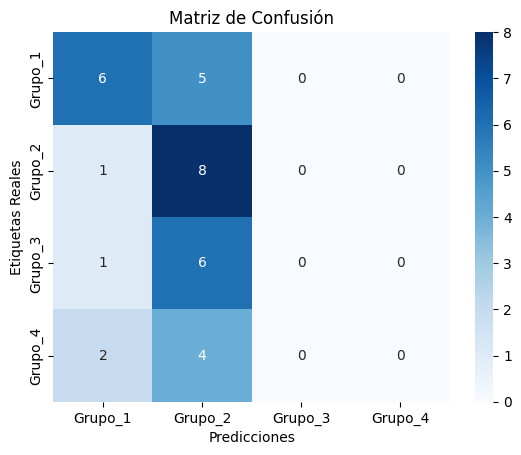

In [665]:
# Calcular la matriz de confusión
y_test_num = y_test.astype(int)
matrix = confusion_matrix(np.argmax(y_test_num, axis=1), np.argmax(y_pred, axis=1))

print(accuracy)
# Visualizar la matriz de confusión con seaborn
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4'], yticklabels=['Grupo_1', 'Grupo_2', 'Grupo_3', 'Grupo_4'])
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Reales")
plt.title("Matriz de Confusión")
plt.show()

# Funcion



In [483]:
def predecir_grupo(iluminancia, temperatura, modelo):
    # Crear un DataFrame con las variables de entrada
    datos = pd.DataFrame({'Illuminance': [iluminancia], 'Temperature': [temperatura]})

    # Realizar la predicción utilizando el modelo
    predicciones = modelo.predict(datos)

    return predicciones[0]

# Ejemplo de uso:
iluminancia_input = 500  # reemplaza con el valor real
temperatura_input = 4000 # reemplaza con el valor real

predecir_grupo(iluminancia_input,temperatura_input, model)

array([0., 0., 0., 0.])